In [15]:
filename = "../data/2021018ISA_data_from_Steve/101.txt" #path to datafile
outfile = "../data/2021018ISA_data_from_Steve/101_results.txt"
m0Mz = 255.232405
numCarbons = 16
polarity = "negative" #ionization polarity 
ppmThresh = 50 #m/z tolerance, all peaks within ppmThresh ppm will be summed into one feature
convSquare = 3 #size of filter (1=1x1,3=3x3,5=5x5)
colormap = "gray" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
num_cores = 20 #number of processor cores to use
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
filt = "GB" #filtering method (GB = gaussian blur, MA = moving average)


In [27]:
#load libraries
import SIMSIToolBox
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import os
import zipfile
import numpy as np
from sklearn.metrics import r2_score


In [3]:
#calculate relevant m/z's
mzsOI = [m0Mz + 1.00336*x for x in range(numCarbons+1)]

In [4]:
#read data
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores)
if ".imzML" in filename:
    msi.readimzML(filename)
else:
    msi.readHDIOutput(filename,polarity)

Text(0.5, 1.0, 'TIC')

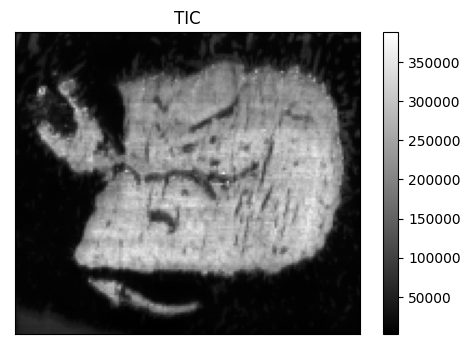

In [5]:
#show TIC image
SIMSIToolBox.showImage(msi.tic_image,cmap=colormap)
plt.title("TIC")

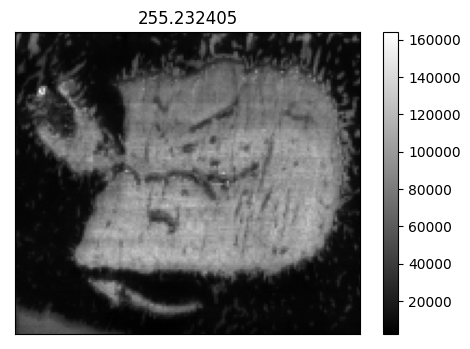

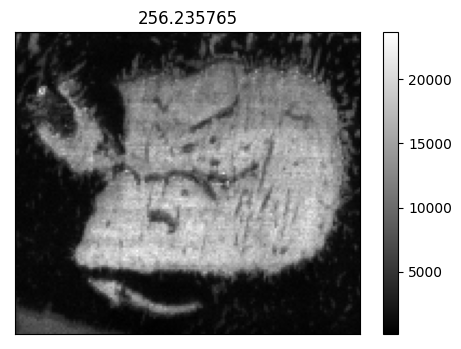

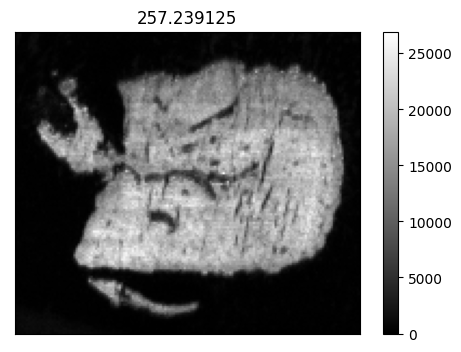

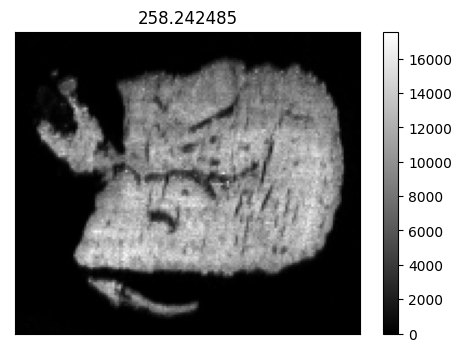

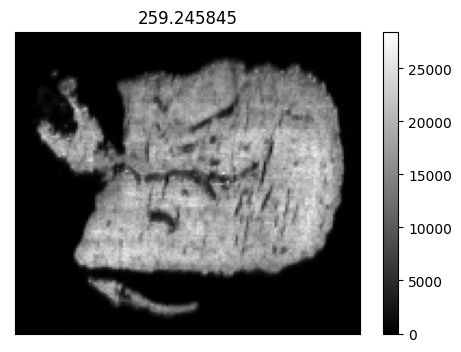

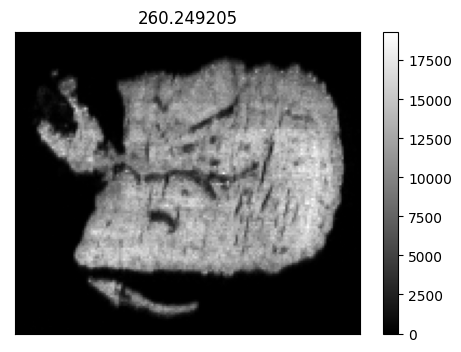

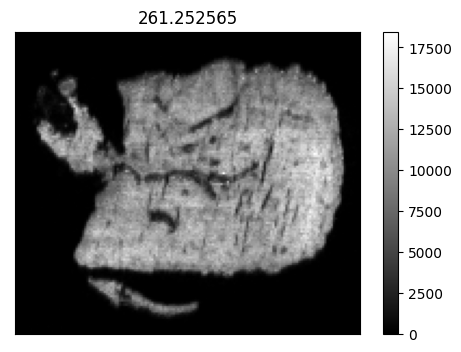

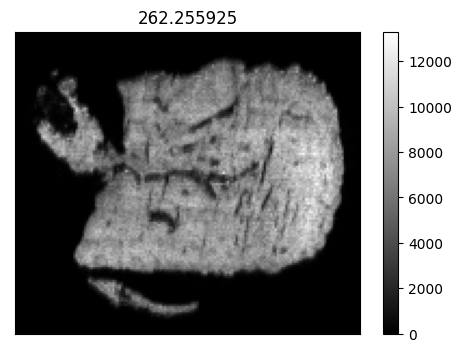

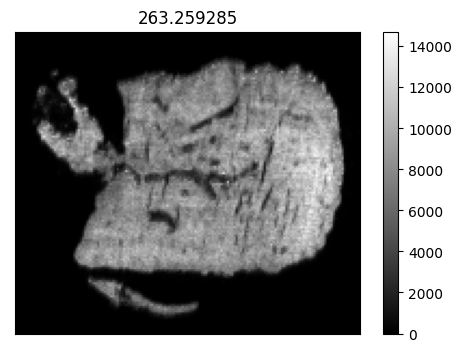

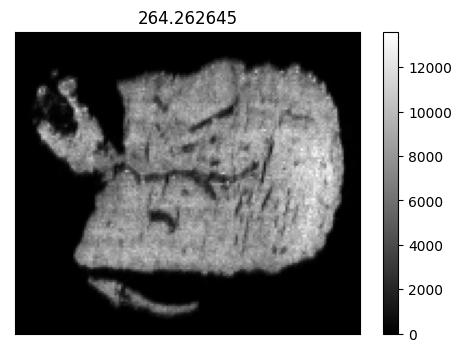

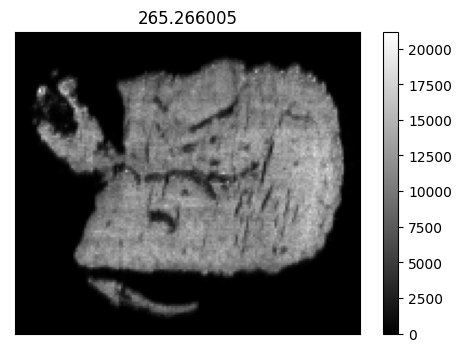

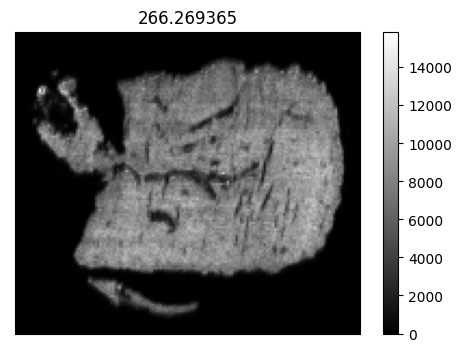

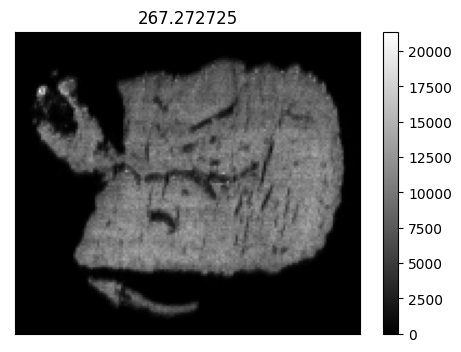

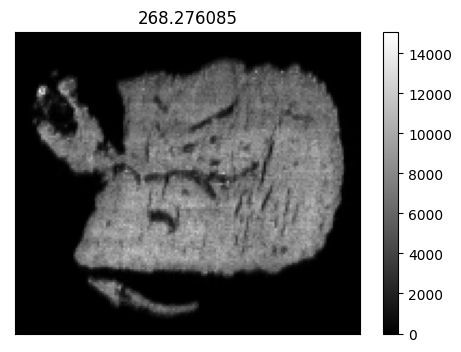

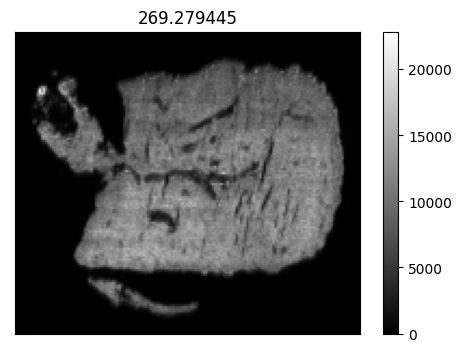

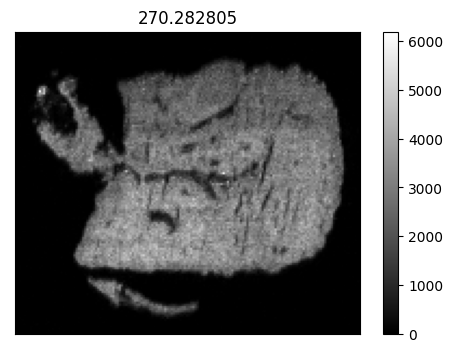

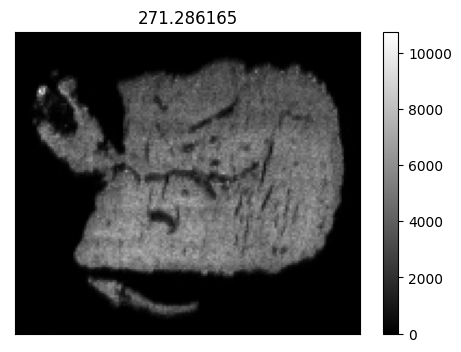

In [6]:
#show images of mzs of interest
for mz,image in zip(msi.targets,msi.data_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)

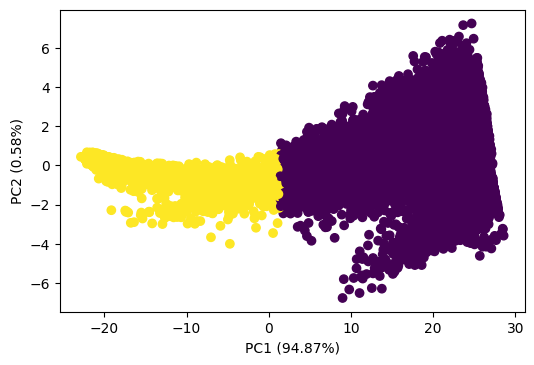

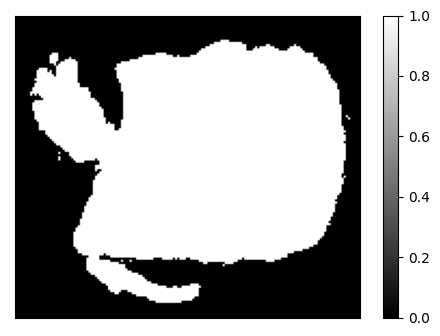

In [7]:
#segment image to remove background
msi.segmentImage(method=seg_method)
plt.figure()
SIMSIToolBox.showImage(msi.imageBoundary,cmap=colormap)

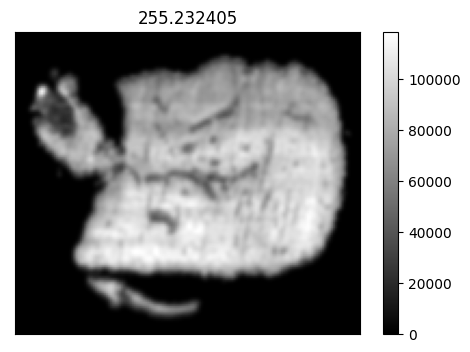

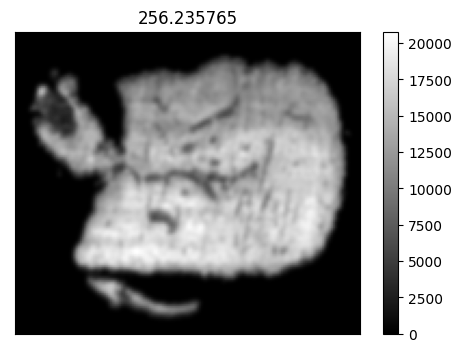

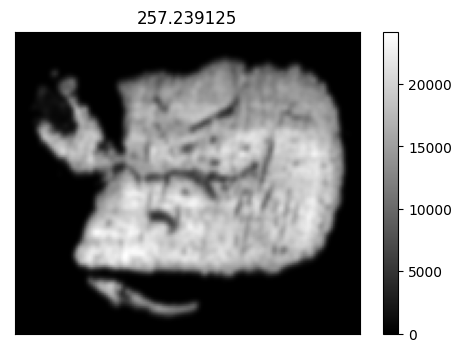

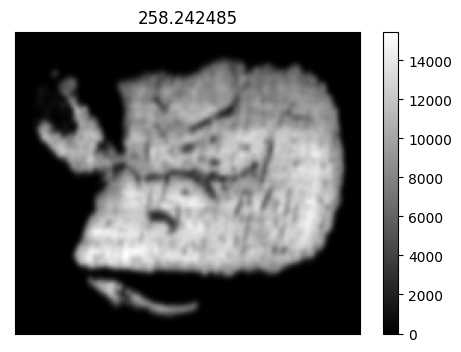

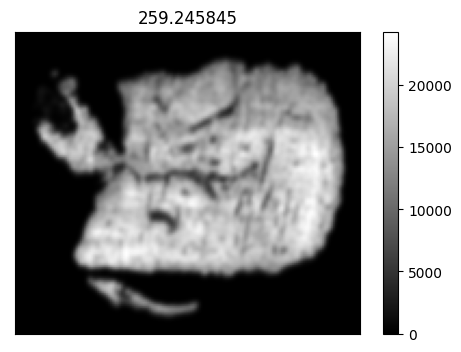

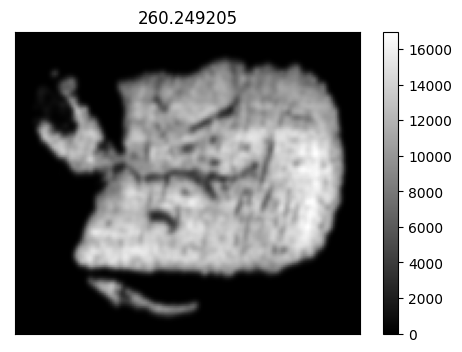

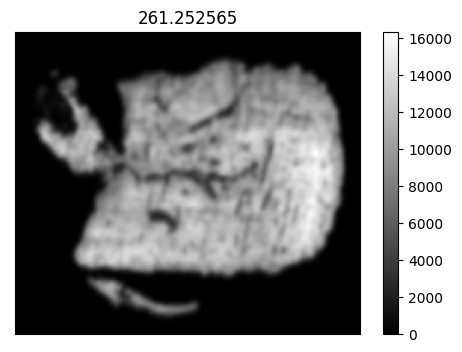

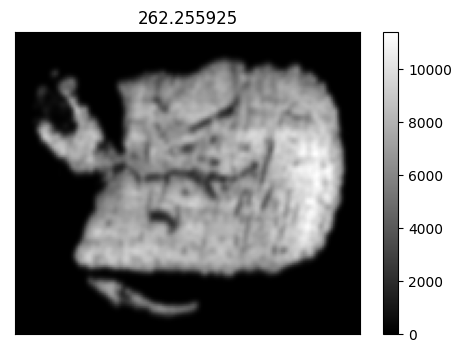

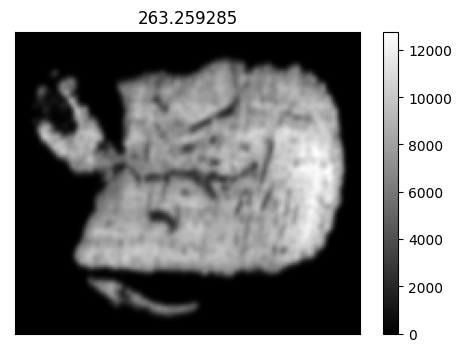

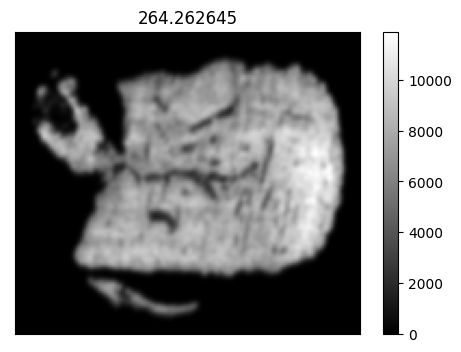

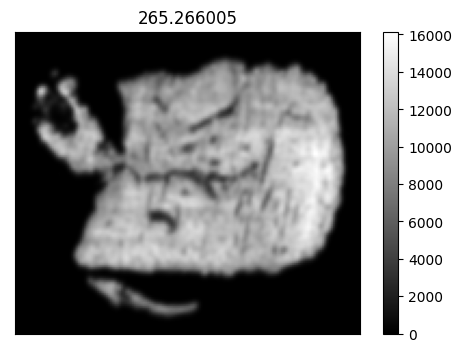

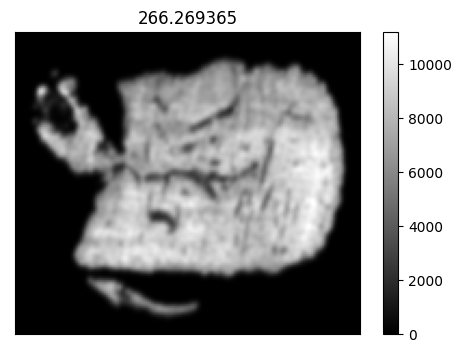

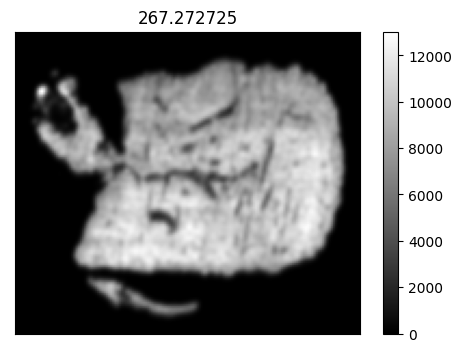

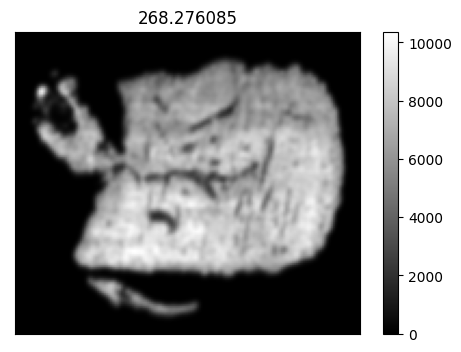

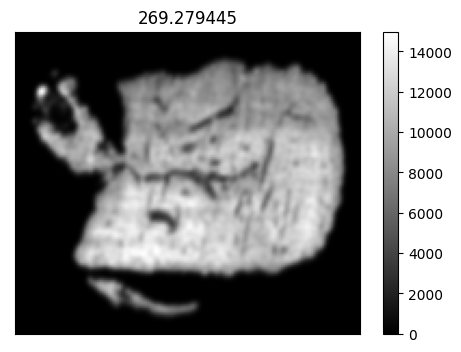

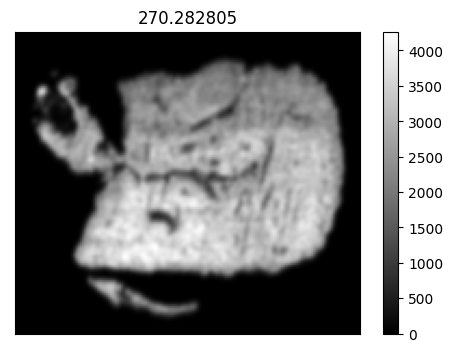

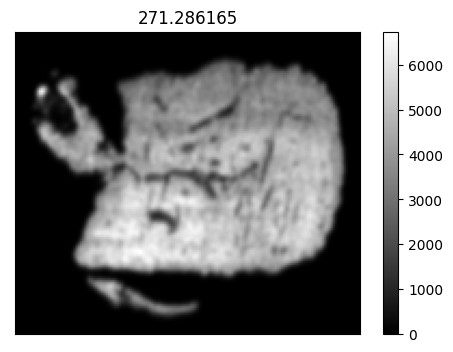

In [8]:
#smooth data and show smoothed result
if __name__ == "__main__":
    msi.smoothData(filt,convSquare)
    for mz,image in zip(msi.targets,msi.data_tensor):
        plt.figure()
        SIMSIToolBox.showImage(image,cmap=colormap)
        plt.title(mz)

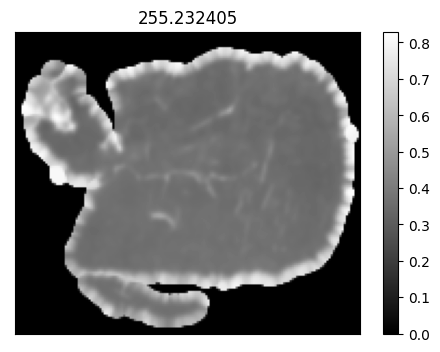

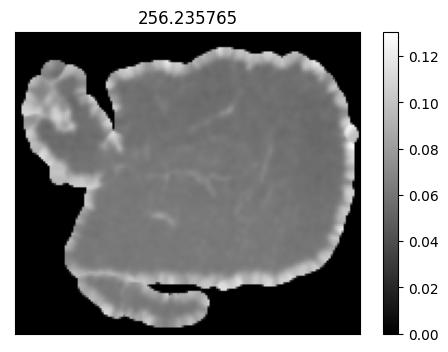

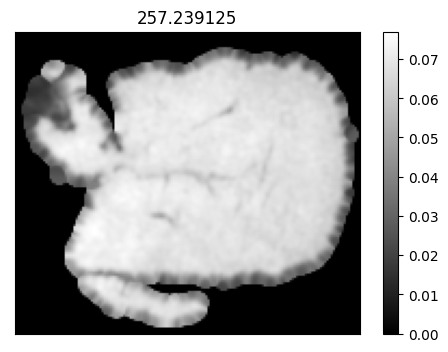

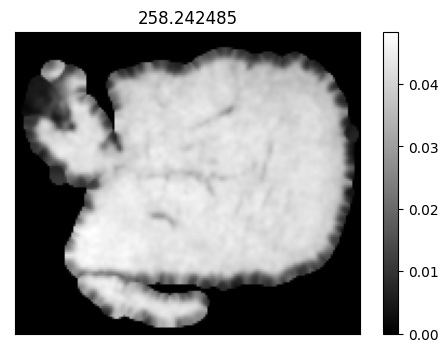

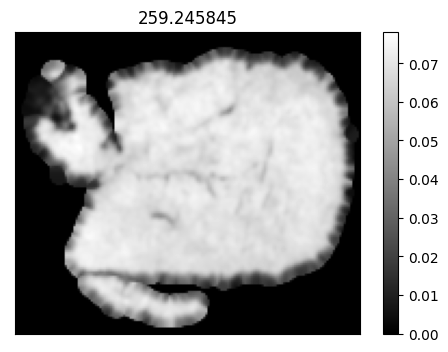

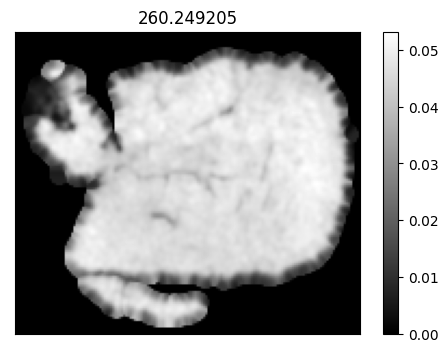

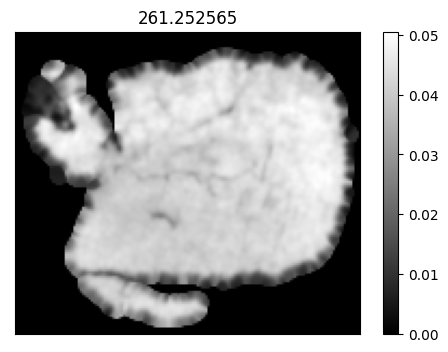

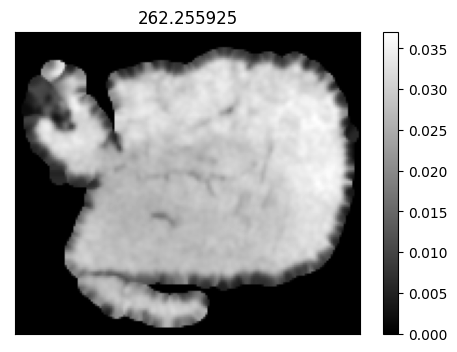

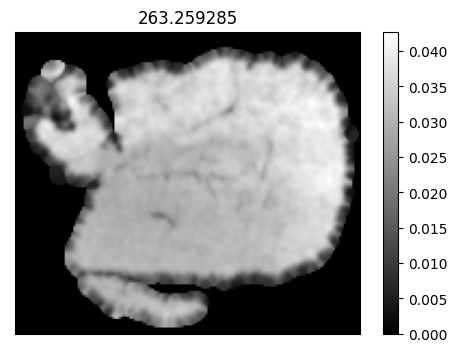

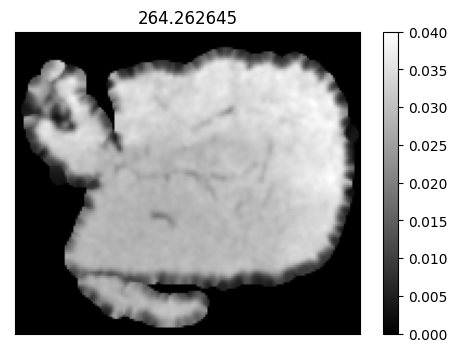

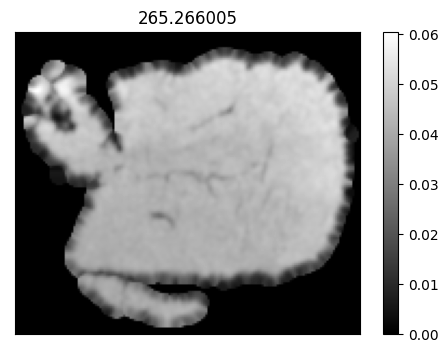

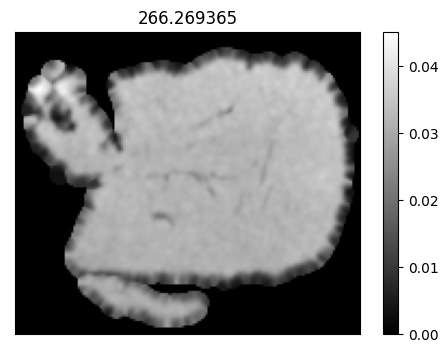

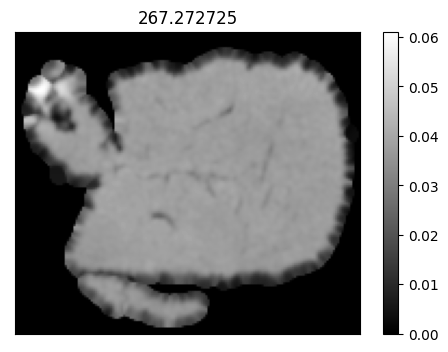

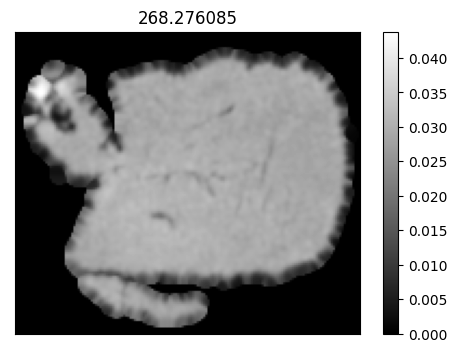

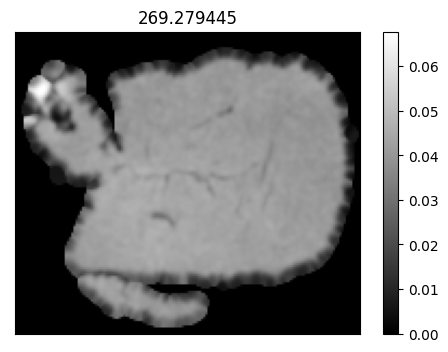

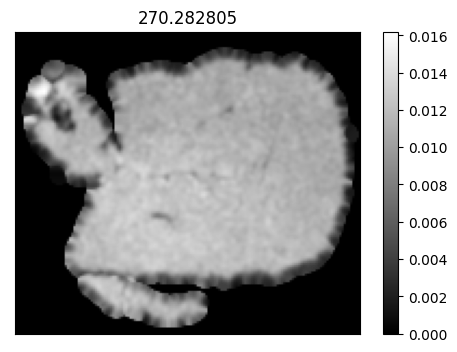

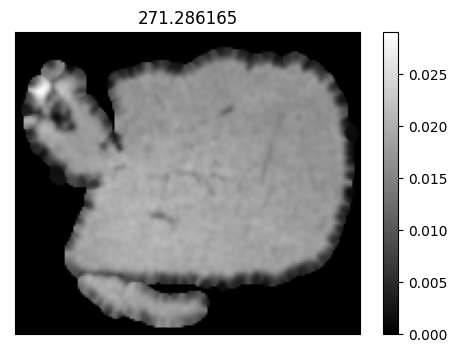

In [9]:
#calculation labeling pattern images and save result
iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor)
counter = 0
for mz,image in zip(msi.targets,iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)
    SIMSIToolBox.saveTIF(image,filename.replace(filename.split(".")[-1],"_" + str(m0Mz) + "_M" + str(counter) + ".tif"))
    counter += 1

In [10]:
if __name__ == "__main__":
    fluxImageG,fluxImageD,fluxImageT0,fluxImageT1,fluxImageT2,T_founds,P_trues,P_preds,numFounds,errs,errors = msi.runISA()

T (mean) =  [0.59143992 0.09302193 0.31553815]


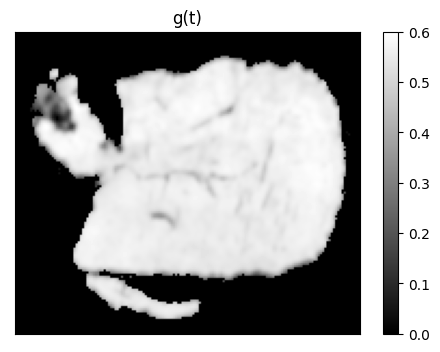

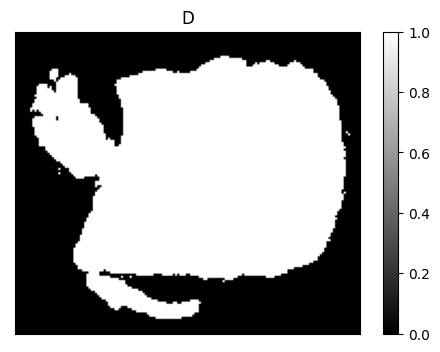

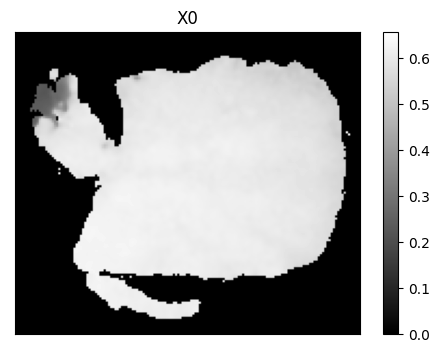

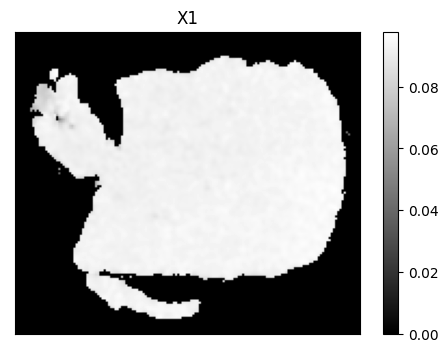

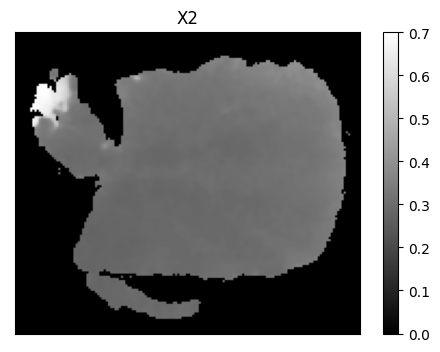

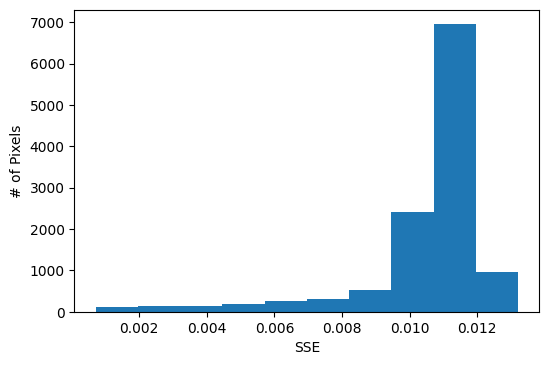

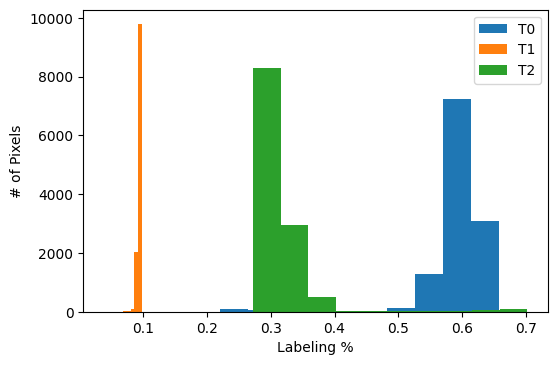

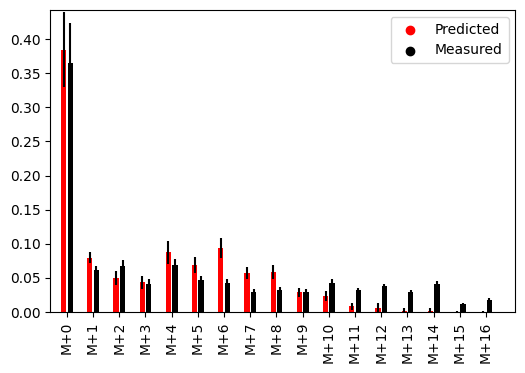

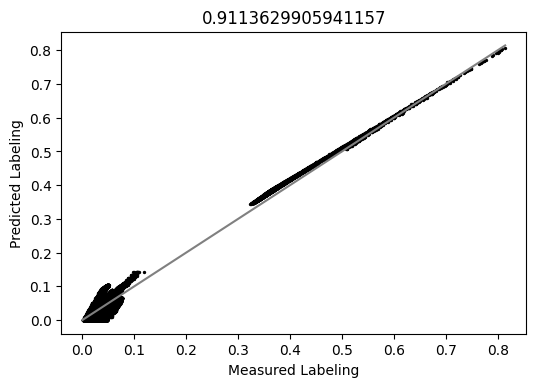

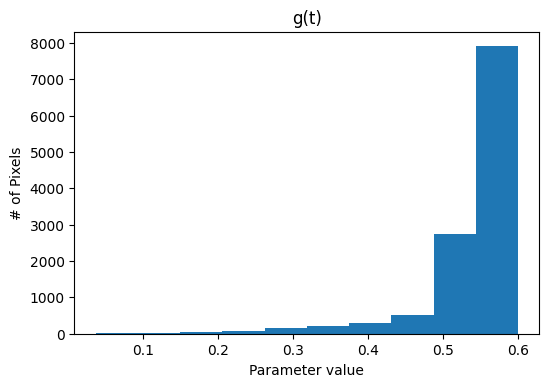

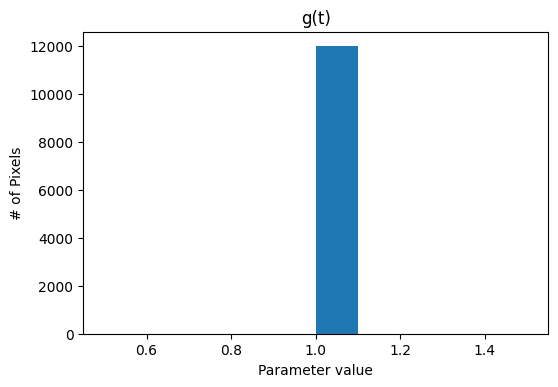

In [29]:
myzip = zipfile.ZipFile(outfile,"w")

#show and save images
for image,label in zip([fluxImageG,fluxImageD,fluxImageT0,fluxImageT1,fluxImageT2],["g(t)","D","X0","X1","X2"]):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(label)
    SIMSIToolBox.saveTIF(image,label + ".tif")
    SIMSIToolBox.write_file_to_zip(myzip,label + ".tif")
    os.remove(label + ".tif")
    

#plot histogram of sum of squared errors
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("# of Pixels")
plt.savefig('sse.png')
SIMSIToolBox.write_file_to_zip(myzip,'sse.png')
os.remove('sse.png')

#output found tracer labeling
plt.figure()
T_founds = np.array([t/np.sum(t) for t in T_founds])
T_found = np.mean(T_founds,axis=0)
print("T (mean) = ",T_found)
for t in range(len(T_found)):
    plt.hist(T_founds[:,t],label="T"+str(t))
plt.legend()
plt.xlabel("Labeling %")
plt.ylabel("# of Pixels")
plt.savefig('X_hist.png')
SIMSIToolBox.write_file_to_zip(myzip,'X_hist.png')
os.remove('X_hist.png')

#show fit vs observed product labeling
plt.figure()
x_ind = 0
x_lab = []
meanPred = np.median(P_preds,axis=0)
stdPred = np.std(P_preds,axis=0)
meanTrue = np.median(P_trues,axis=0)
stdTrue = np.std(P_trues,axis=0)
maxY = np.max(np.concatenate((meanPred,meanTrue))) + np.max(np.concatenate((stdPred,stdTrue)))
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)
plt.scatter([-1],[-1],c="red",label="Predicted")
plt.scatter([-1],[-1],c="black",label="Measured")
plt.legend()
plt.ylim((0,maxY))
plt.xlim((-2,x_ind+1))
plt.savefig('fit_obs_bar.png')
SIMSIToolBox.write_file_to_zip(myzip,'fit_obs_bar.png')
os.remove('fit_obs_bar.png')

plt.figure()
plt.scatter(np.array(P_trues).flatten(),np.array(P_preds).flatten(),color="black",s=2)
plt.ylabel("Predicted Labeling")
plt.xlabel("Measured Labeling")
plt.title(r2_score(np.array(P_trues).flatten(),np.array(P_preds).flatten()))
plt.plot([0,np.max(np.concatenate((P_trues,P_preds)))],[0,np.max(np.concatenate((P_trues,P_preds)))],color="grey")
plt.savefig('fit_obs_scatter.png')
SIMSIToolBox.write_file_to_zip(myzip,'fit_obs_scatter.png')
os.remove('fit_obs_scatter.png')

for image,label in zip([fluxImageG,fluxImageD],["g(t)","D"]):
    plt.figure()
    plt.hist(image[image > 0].flatten())
    plt.title("g(t)")
    plt.xlabel("Parameter value")
    plt.ylabel("# of Pixels")
    plt.savefig(label + '_hist.png')
    SIMSIToolBox.write_file_to_zip(myzip,label + '_hist.png')
    os.remove(label + '_hist.png')


myzip.close()